In [ ]:
from math import sqrt
import numpy as np

# Read Opta F24 Events

Functions retrieved from notebook made available on the course page

In [ ]:
import xml.etree.ElementTree as et
#from lxml import etree
import pandas as pd
from IPython.core import display as ICD
from pandas import json_normalize
import pandas as pd
#import tqdm as tqdm
from tqdm.notebook import tqdm
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
from datetime import datetime
import time

#@title
types_dict={1:"Pass",2:"Offside Pass",3:"Take On",4:"Foul",5:"Out",6:"Corner Awarded",7:"Tackle",8:"Interception",9:"Turnover",10:"Save",11:"Claim",12:"Clearance",13:"Miss",14:"Post",15:"Attempt Saved",16:"Goal",17:"Card",18:"Player off",19:"Player on",20:"Player retired",21:"Player returns",22:"Player becomes goalkeeper",23:"Goalkeeper becomes player",24:"Condition change",25:"Official change",27:"Start delay",28:"End delay",30:"End",31:"Picked an orange",32:"Start",34:"Team set up",35:"Player changed position",36:"Player changed Jersey number",37:"Collection End",38:"Temp_Goal",39:"Temp_Attempt",40:"Formation change",41:"Punch",42:"Good Skill",43:"Deleted event",44:"Aerial",45:"Challenge",47:"Rescinded card",49:"Ball recovery",50:"Dispossessed",51:"Error",52:"Keeper pick-up",53:"Cross not claimed",54:"Smother",55:"Offside provoked",56:"Shield ball opp",57:"Foul throw-in",58:"Penalty faced",59:"Keeper Sweeper",60:"Chance missed",61:"Ball touch",63:"Temp_Save",64:"Resume",65:"Contentious referee decision",67:"50/50",68:"Referee drop ball",69:"Failed To Block",72:"Caught offside",73:"Other Ball Contact",74:"Blocked pass"};
types = pd.DataFrame.from_dict(types_dict,orient='index').reset_index()
types.columns=["type_id","event_name"]

qualifiers_dict={1:"Long ball",2:"Cross",3:"Head pass",4:"Through ball",5:"Free kick taken",6:"Corner taken",7:"Players caught offside",8:"Goal disallowed",9:"Penalty",10:"Hand",11:"6-seconds violation",12:"Dangerous play",13:"Foul",14:"Last line",15:"Head",16:"Small box-centre",17:"Box-centre",18:"Out of box-centre",19:"35+ centre",20:"Right footed",21:"Other body part",22:"Regular play",23:"Fast break",24:"Set piece",25:"From corner",26:"Free kick",28:"Own goal",29:"Assisted",30:"Involved",31:"Yellow Card",32:"Second yellow",33:"Red card",34:"Referee abuse",35:"Argument",36:"Fight",37:"Time wasting",38:"Excessive celebration",39:"Crowd interaction",40:"Other reason",41:"Injury",42:"Tactical",44:"Player position",49:"Attendance figure",50:"Official position",51:"Official ID",53:"Injured player id",54:"End cause",55:"Related event ID",56:"Zone",57:"End type",59:"Jersey number",60:"Small box-right",61:"Small box-left",62:"Box-deep right",63:"Box-right",64:"Box-left",65:"Box-deep left",66:"Out of box-deep right",67:"Out of box-right",68:"Out of box-left",69:"Out of box-deep left",70:"35+ right",71:"35+ left",72:"Left footed",73:"Left",74:"High",75:"Right",76:"Low left",77:"High left",78:"Low centre",79:"High centre",80:"Low right",81:"High right",82:"Blocked",83:"Close left",84:"Close right",85:"Close high",86:"Close left and high",87:"Close right and high",88:"High claim",89:"1 on 1",90:"Deflected save",91:"Dive and deflect",92:"Catch",93:"Dive and catch",94:"Def block",95:"Back pass",96:"Corner situation",97:"Direct free",100:"Six yard blocked",101:"Saved off line",102:"Goal mouth y co-ordinate",103:"Goal mouth z co-ordinate",106:"Attacking Pass",107:"Throw-in",108:"Volley",109:"Overhead",110:"Half Volley",111:"Diving Header",112:"Scramble",113:"Strong",114:"Weak",115:"Rising",116:"Dipping",117:"Lob",118:"One Bounce",119:"Few Bounces",120:"Swerve Left",121:"Swerve Right",122:"Swerve Moving",123:"Keeper Throw",124:"Goal Kick",127:"Direction of play",128:"Punch",130:"Team formation",131:"Team player formation",132:"Dive",133:"Deflection",134:"Far Wide Left",135:"Far Wide Right",136:"Keeper Touched",137:"Keeper Saved",138:"Hit Woodwork",139:"Own Player",140:"Pass End X",141:"Pass End Y",144:"Deleted event type",145:"Formation slot",146:"Blocked x co-ordinate",147:"Blocked y co-ordinate",153:"Not past goal line",154:"Intentional assist",155:"Chipped",156:"Lay-off",157:"Launch",158:"Persistent infringement",159:"Foul and abusive language",160:"Throw-in set piece",161:"Encroachment",162:"Leaving field",163:"Entering field",164:"Spitting",165:"Professional foul",166:"Handling on the line",167:"Out of play",168:"Flick-on",169:"Leading to attempt",170:"Leading to goal",171:"Rescinded card",172:"No impact on timing",173:"Parried safe",174:"Parried danger",175:"Fingertip",176:"Caught",177:"Collected",178:"Standing",179:"Diving",180:"Stooping",181:"Reaching",182:"Hands",183:"Feet",184:"Dissent",185:"Blocked cross",186:"Scored",187:"Saved",188:"Missed",189:"Player not visible",190:"From shot off target",191:"Off the ball foul",192:"Block by hand",194:"Captain",195:"Pull Back",196:"Switch of play",197:"Team kit",198:"GK hoof",199:"Gk kick from hands",200:"Referee stop",201:"Referee delay",202:"Weather problem",203:"Crowd trouble",204:"Fire",205:"Object thrown on pitch",206:"Spectator on pitch",207:"Awaiting officials decision",208:"Referee Injury",209:"Game end",210:"Assist",211:"Overrun",212:"Length",213:"Angle",214:"Big Chance",215:"Individual Play",216:"2nd related event ID",217:"2nd assisted",218:"2nd assist",219:"Players on both posts",220:"Player on near post",221:"Player on far post",222:"No players on posts",223:"In-swinger",224:"Out-swinger",225:"Straight",226:"Suspended",227:"Resume",228:"Own shot blocked",229:"Post-match complete",230:"GK X Coordinate",231:"GK Y Coordinate",232:"Unchallenged"};
qualifiers = pd.DataFrame.from_dict(qualifiers_dict,orient='index').reset_index()
qualifiers.columns = ["qualifier_id","description"]

qualifiers_dict2 = {str(key): str(value) for key, value in qualifiers_dict.items()}


def parsef24_folder(F24folder):
  games_list = []
  events_list = []

  for file in tqdm(os.listdir(F24folder)):
    if file.endswith(".xml"):
      file_path = os.path.join(F24folder, file)
      #print(f"Processing: {file_path}")

      tree = et.ElementTree(file=file_path)
      games = tree.getroot()
      gameinfo = games.findall('Game')[0]  # Assuming there's always one 'Game' element

      # Cache game metadata
      game_id = gameinfo.get('id')
      game_meta = {
          "game_id": game_id,
          "home_team_id": gameinfo.get('home_team_id'),
          "home_team_name": gameinfo.get('home_team_name'),
          "away_team_id": gameinfo.get('away_team_id'),
          "away_team_name": gameinfo.get('away_team_name'),
          "competition_id": gameinfo.get('competition_id'),
          "competition_name": gameinfo.get('competition_name'),
          "season_id": gameinfo.get('season_id'),
      }
      games_list.append(game_meta)

      for game in games:
        for event in game:
          # Build a dictionary for the event data
          event_data = event.attrib.copy()
          # Use list comprehension to extract qualifiers
          event_data["qualifiers"] = [q.attrib for q in event]
          event_data["game_id"] = game_id  # Attach game metadata to event
          # Build a DataFrame for this event and append it to the list
          events_list.append(event_data)

  # Concatenate all parsed events into a single DataFrame
  game_df = pd.DataFrame(games_list)
  match_events = pd.DataFrame(events_list)

  match_events[["id","event_id","type_id","period_id","min","sec"]] = match_events[["id","event_id","type_id","period_id","min","sec"]].astype(int)
  match_events[["y","x"]] = match_events[["y","x"]].astype(float)
  match_events = pd.merge(match_events,types, on="type_id", how = "left")
  match_events = match_events[ ['id',"event_id","type_id", "event_name" ]+ [ col for col in match_events.columns if col not in ['id',"event_id","type_id", "event_name" ] ] ]

  # add game info to match_events
  match_events = pd.merge(match_events, game_df, on="game_id", how="inner")

  return match_events


def explode_event(nome_df, id_evento, mytresh):
    # Filter the dataframe for the required event type
    nome_df = nome_df[nome_df["type_id"] == id_evento].copy()

    if nome_df.empty:
        return pd.DataFrame()  # Return empty if no matching events

    # Explode 'qualifiers' column (assuming it's a list of dictionaries)
    nome_df_exploded = nome_df.explode("qualifiers")

    # Normalize the qualifiers column
    qualifiers_df = pd.json_normalize(nome_df_exploded["qualifiers"]).fillna("yes")

    # Add the event ID back to qualifiers_df
    qualifiers_df["id"] = nome_df_exploded["id"].values

    # pivot table
    qualifiers_df = qualifiers_df\
      .pivot_table(index='id', columns='qualifier_id', values='value', aggfunc='first')\
      .reset_index()

    # Rename columns based on your dictionary
    qualifiers_df.rename(columns=qualifiers_dict2, inplace=True)

    # Drop columns that have too many NaN values
    min_non_na = len(qualifiers_df) * mytresh
    qualifiers_df = qualifiers_df.dropna(thresh=min_non_na, axis=1)

    # Drop the original exploded 'qualifiers' column
    nome_df = nome_df.drop(columns=["qualifiers"])

    # Merge back
    exploded_df = nome_df.merge(qualifiers_df, on="id", how="outer").fillna("-")

    return exploded_df

# Paths

In [ ]:
player_name_path = "/content/opta_planteis_portugal.xlsx"
player_name_path_fbref = "/content/fbref_player_data.xlsx"
f24_folder_path = "/content/"

# Read data

In [ ]:
match_events = parsef24_folder(f24_folder_path)

  0%|          | 0/303 [00:00<?, ?it/s]

# Get players' play time

In [ ]:
# relevant ids
starting_eleven_id = 34
player_off_id = 18
player_on_id = 19

## Starting 11

In [ ]:
# get starting eleven players
starting_eleven = explode_event(match_events, starting_eleven_id, 0)[['game_id', 'team_id', 'Involved']]
## get only first 11 players involved
starting_eleven['Involved'] = starting_eleven['Involved'].str.split(',').str[:11]\
  .apply(lambda x: [name.strip() for name in x])  # Remove spaces
## explode 'Involved' column
starting_eleven = starting_eleven.explode('Involved')
starting_eleven = starting_eleven.reset_index(drop=True)\
  .rename(columns={'Involved': 'player_id'})
starting_eleven['start_time'] = 0
starting_eleven

,game_id,team_id,player_id,start_time
0,2133169,6644,199209,0
1,2133169,6644,176486,0
2,2133169,6644,180182,0
3,2133169,6644,171349,0
4,2133169,6644,246998,0
...,...,...,...,...
6595,2133472,740,195447,0
6596,2133472,740,129494,0
6597,2133472,740,202620,0
6598,2133472,740,226949,0


## Sub ons

In [ ]:
sub_ons = match_events[match_events['type_id'] == player_on_id][['game_id', 'team_id', 'player_id', 'min']]\
  .rename(columns={'min': 'start_time'}).reset_index(drop=True)
sub_ons

,game_id,team_id,player_id,start_time
0,2133444,251,131416,67
1,2133444,251,39765,67
2,2133444,201,178867,68
3,2133444,201,437860,68
4,2133444,201,444102,82
...,...,...,...,...
2606,2133231,3084,89040,83
2607,2133231,3084,102025,83
2608,2133231,3084,241188,84
2609,2133231,6685,219716,91


## Sub offs

In [ ]:
sub_offs = match_events[match_events['type_id'] == player_off_id][['game_id', 'team_id', 'player_id', 'min']]\
  .rename(columns={'min': 'end_time'}).reset_index(drop=True)
sub_offs

,game_id,team_id,player_id,end_time
0,2133444,251,179411,67
1,2133444,251,148515,67
2,2133444,201,204152,68
3,2133444,201,486212,68
4,2133444,201,202604,82
...,...,...,...,...
2606,2133231,3084,181180,83
2607,2133231,3084,103488,83
2608,2133231,3084,455804,84
2609,2133231,6685,442853,91


## Merge All together

In [ ]:
starting_eleven.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   game_id     6600 non-null   object
 1   team_id     6600 non-null   object
 2   player_id   6600 non-null   object
 3   start_time  6600 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 206.4+ KB


In [ ]:
sub_ons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   game_id     2611 non-null   object
 1   team_id     2611 non-null   object
 2   player_id   2611 non-null   object
 3   start_time  2611 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 81.7+ KB


In [ ]:
sub_offs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   game_id    2611 non-null   object
 1   team_id    2611 non-null   object
 2   player_id  2611 non-null   object
 3   end_time   2611 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 81.7+ KB


In [ ]:
play_time = pd.concat([starting_eleven, sub_ons], axis=0)
play_time = pd.merge(play_time, sub_offs, on=['game_id', 'team_id', 'player_id'], how='left')
play_time['end_time'] = play_time['end_time'].fillna(90)
play_time['play_time'] = play_time['end_time'] - play_time['start_time']

# limit play_time to 90 minutes
play_time['play_time'] = play_time['play_time'].clip(upper=90)
play_time = play_time.drop(['start_time', 'end_time'], axis=1)

# get only players with play_time >= 30'
play_time = play_time[play_time['play_time'] >= 30]

play_time

,game_id,team_id,player_id,play_time
0,2133169,6644,199209,90.0
1,2133169,6644,176486,45.0
2,2133169,6644,180182,45.0
3,2133169,6644,171349,90.0
4,2133169,6644,246998,90.0
...,...,...,...,...
9161,2133426,201,244731,30.0
9162,2133426,201,178867,30.0
9178,2133228,3536,222630,35.0
9187,2133353,2003,52698,45.0


# Define zones

The pitch is split into 9 zones, but opposite lateral areas are considered the same zone (so that we don't have a bias towards players that switched flanks during the game)

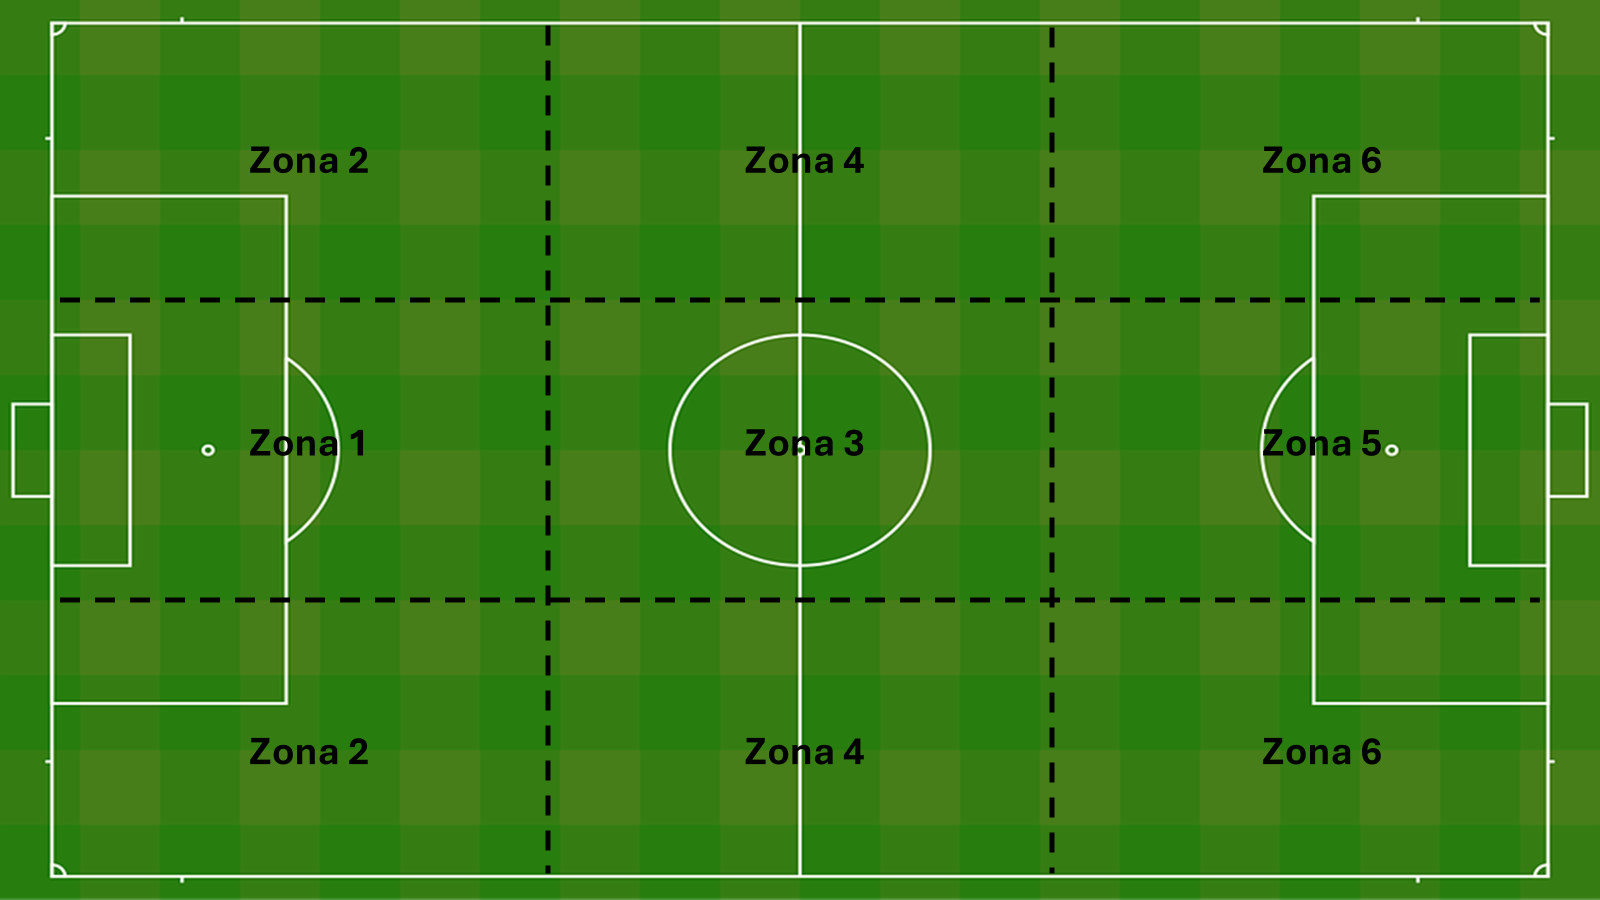

In [ ]:
# parameters
zones = 9
zone_map = [2,1,2,4,3,4,6,5,6]

In [ ]:
def assign_zone(x, y, x_min_max=(0, 100), y_min_max=(0, 100), zones = zones, zone_map = zone_map):
    """
    Assigns a zone based on x, y coordinates.

    Parameters:
    x (float): X-coordinate on the pitch.
    y (float): Y-coordinate on the pitch.
    x_min_max (tuple): Min and max range for x-coordinates.
    y_min_max (tuple): Min and max range for y-coordinates.
    zones (int): Number of zones.
    zone_map (list): List of zones identifiers.

    Returns:
    str: Zone name corresponding to the input coordinates.
    """

    x_y_divisor = sqrt(zones)

    if x_y_divisor != int(x_y_divisor):
        raise ValueError("The number of zones should be a perfect square.")

    if len(zone_map) != zones:
        raise ValueError("The number of zones should match the length of the zone_map list.")

    # split field into 9
    x_step = (x_min_max[1] - x_min_max[0]) / x_y_divisor
    y_step = (y_min_max[1] - y_min_max[0]) / x_y_divisor

    # Determine grid position
    row = int(min((x - x_min_max[0]) / x_step, x_y_divisor-1))  # Ensures max index is 2
    col = int(min((y - y_min_max[0]) / y_step, x_y_divisor-1))

    # Convert row-major indexing to list index
    index = row * 3 + col

    return zone_map[index]


In [ ]:
assign_zone(50,50)

3

# Filter specific events


Ações Defensivas
*   Interceção
*   Desarme (com sucesso)
*   Duelo aéreo ganho


Ações de Construção

*   Passe progressivo
*   Condução progressiva (ignorada - pois não existem conduções)
*   Drible
*   Duelo ofensivo ganho (excluindo dribles) (vamos ignorar também, não existe este evento)


Ações ofensivas
*   Passes chave
*   Deep completition (incluindo cruzamentos)
*   Remate à baliza





In [ ]:
# defensive actions
interception_id = 8
tackle_id = 7
aerial_id = 44

# possession actions
pass_id = 1  # we can use the pass start and end to calculate the progressive passes
length_threshold = [30, 15, 10] # meters closer to goal
dribble_id = 3 # (Take on)

# offensive actions (key passes already included in pass_id)
length_deep_completition = 20 # meters to goal
shots_saved_id = 15 # shots saved/blocked (explode 15 to remove blocked shots)
goals_id = 16 # goals

# min,max coordinates
x_min_max = (0, 100)
y_min_max = (0, 100)

# pitch size
pitch_length = 105
pitch_width = 68

In [ ]:
match_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531988 entries, 0 to 531987
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                531988 non-null  int64  
 1   event_id          531988 non-null  int64  
 2   type_id           531988 non-null  int64  
 3   event_name        527978 non-null  object 
 4   period_id         531988 non-null  int64  
 5   min               531988 non-null  int64  
 6   sec               531988 non-null  int64  
 7   team_id           531988 non-null  object 
 8   outcome           531988 non-null  object 
 9   x                 531988 non-null  float64
 10  y                 531988 non-null  float64
 11  timestamp         531988 non-null  object 
 12  last_modified     531988 non-null  object 
 13  version           531983 non-null  object 
 14  qualifiers        531988 non-null  object 
 15  game_id           531988 non-null  object 
 16  player_id         52

In [ ]:
match_events['outcome'] = match_events['outcome'].astype(int)
match_events['outcome'].drop_duplicates()

,outcome
0,1
6,0


## Defensive Actions

In [ ]:
defensive_actions = match_events[match_events['type_id'].isin([interception_id,tackle_id,aerial_id])]
defensive_actions_successful = defensive_actions[defensive_actions['outcome']==1]  # get only successful actions
defensive_actions_successful = defensive_actions_successful[['game_id', 'team_id', 'player_id', 'event_name', 'x', 'y']]

# assign corresponding zone
defensive_actions_successful['zone'] = defensive_actions_successful.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)

# group by game, player, action, and zone
defensive_actions_successful = defensive_actions_successful\
  .groupby(['game_id', 'team_id', 'player_id', 'event_name', 'zone']).size().reset_index(name='count')
defensive_actions_successful

,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,Aerial,2,1
1,2133169,251,106004,Aerial,4,1
2,2133169,251,106004,Interception,1,1
3,2133169,251,106004,Interception,2,1
4,2133169,251,106004,Tackle,4,1
...,...,...,...,...,...,...
17928,2133474,2847,52980,Tackle,2,1
17929,2133474,2847,52980,Tackle,4,2
17930,2133474,2847,59229,Tackle,1,1
17931,2133474,2847,59229,Tackle,4,1


## Passes

In [ ]:
match_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531988 entries, 0 to 531987
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                531988 non-null  int64  
 1   event_id          531988 non-null  int64  
 2   type_id           531988 non-null  int64  
 3   event_name        527978 non-null  object 
 4   period_id         531988 non-null  int64  
 5   min               531988 non-null  int64  
 6   sec               531988 non-null  int64  
 7   team_id           531988 non-null  object 
 8   outcome           531988 non-null  int64  
 9   x                 531988 non-null  float64
 10  y                 531988 non-null  float64
 11  timestamp         531988 non-null  object 
 12  last_modified     531988 non-null  object 
 13  version           531983 non-null  object 
 14  qualifiers        531988 non-null  object 
 15  game_id           531988 non-null  object 
 16  player_id         52

In [ ]:
# only consider successful passes (with outcome 1)
passes_df = match_events[(match_events['type_id']==pass_id) & (match_events['outcome']==1)]

In [ ]:
# explode passes
passes_exploded = explode_event(passes_df, pass_id, 0.15)
passes_exploded['pass_end_x'] = passes_exploded['Pass End X'].astype('float')
passes_exploded['pass_end_y'] = passes_exploded['Pass End Y'].astype('float')
passes_exploded = passes_exploded[['game_id', 'team_id', 'player_id', 'event_name', 'x', 'y', 'pass_end_x', 'pass_end_y']]
passes_exploded

,game_id,team_id,player_id,event_name,x,y,pass_end_x,pass_end_y
0,2133169,251,131416,Pass,49.7,50.0,51.8,52.5
1,2133169,251,39765,Pass,51.8,52.5,40.5,92.6
2,2133169,251,106004,Pass,54.2,93.0,43.7,85.0
3,2133169,251,131416,Pass,44.8,88.6,46.0,96.3
4,2133169,251,106004,Pass,46.0,96.3,56.5,94.7
...,...,...,...,...,...,...,...,...
209347,2133467,1981,229680,Pass,59.0,85.0,71.3,96.2
209348,2133467,6685,219716,Pass,37.0,68.9,27.5,55.0
209349,2133467,6685,159716,Pass,39.0,23.4,26.9,26.2
209350,2133408,201,210237,Pass,33.9,26.8,42.2,16.1


In [ ]:
def pass_length(start_x, start_y, end_x, end_y,
                 pitch_length_coord=100, pitch_width_coord=100,
                 pitch_length_meters=105, pitch_width_meters=68):
    """
    Calculates pass progression and final proximity to the opponent's goal.

    Parameters:
    start_x (float): X-coordinate where the pass starts.
    start_y (float): Y-coordinate where the pass starts.
    end_x (float): X-coordinate where the pass ends.
    end_y (float): Y-coordinate where the pass ends.
    pitch_length_coord (int, optional): Field length in coordinate system.
    pitch_width_coord (int, optional): Field width in coordinate system.
    pitch_length_meters (float, optional): Actual pitch length in meters.
    pitch_width_meters (float, optional): Actual pitch width in meters.

    Returns:
    tuple: (progression, end_dist)
        - progression: How much the pass moved closer to the goal (in meters).
        - end_dist: The Euclidean distance (in meters) from the end point of the pass to the opponent's goal.
        - start_half: Which half of the pitch the pass started in ("defensive half" or "attacking half").
        - end_half: Which half of the pitch the pass ended in ("defensive half" or "attacking half").
    """

    # Convert coordinates to meters
    scale_x = pitch_length_meters / pitch_length_coord
    scale_y = pitch_width_meters / pitch_width_coord

    start_x_m = start_x * scale_x
    start_y_m = start_y * scale_y
    end_x_m = end_x * scale_x
    end_y_m = end_y * scale_y

    # Opponent goal center (assumed at far end, middle of width)
    goal_x = pitch_length_meters
    goal_y = pitch_width_meters / 2

    # Compute pass progression (Euclidean distance to goal)
    start_dist = np.sqrt((goal_x - start_x_m)**2 + (goal_y - start_y_m)**2)
    end_dist = np.sqrt((goal_x - end_x_m)**2 + (goal_y - end_y_m)**2)
    progression = start_dist - end_dist

    # Determine which half the pass started and ended in
    half_boundary = pitch_length_meters / 2
    start_half = "defensive half" if start_x_m < half_boundary else "attacking half"
    end_half   = "defensive half" if end_x_m < half_boundary else "attacking half"

    return progression, end_dist, start_half, end_half

In [ ]:
# add progression, end_dist, starting_half, and ending_half to df
# consider only passes with progression > 0
passes_exploded[['pass_progression', 'end_dist', 'start_half', 'end_half']] = passes_exploded.apply(
    lambda row: pd.Series(pass_length(row['x'], row['y'], row['pass_end_x'], row['pass_end_y'])), axis=1)
passes_exploded = passes_exploded[passes_exploded['pass_progression'] > 0]
passes_exploded

,game_id,team_id,player_id,event_name,x,y,pass_end_x,pass_end_y,pass_progression,end_dist,start_half,end_half
0,2133169,251,131416,Pass,49.7,50.0,51.8,52.5,2.176456,50.638544,defensive half,attacking half
4,2133169,251,106004,Pass,46.0,96.3,56.5,94.7,9.990118,54.864583,defensive half,attacking half
5,2133169,251,179531,Pass,56.5,94.7,61.7,91.8,5.618568,49.246015,attacking half,attacking half
7,2133169,251,131416,Pass,53.3,84.4,63.6,71.4,13.432219,40.896566,attacking half,attacking half
8,2133169,251,171314,Pass,37.1,46.4,55.7,7.0,11.148358,54.941995,defensive half,attacking half
...,...,...,...,...,...,...,...,...,...,...,...,...
209344,2133467,6685,508353,Pass,36.9,10.7,39.6,24.8,5.747281,65.694284,defensive half,defensive half
209345,2133467,1981,436806,Pass,28.7,63.1,47.0,91.9,12.873378,62.519729,defensive half,defensive half
209346,2133467,6685,442853,Pass,37.2,64.0,59.4,67.1,22.436264,44.187411,defensive half,attacking half
209347,2133467,1981,229680,Pass,59.0,85.0,71.3,96.2,5.658324,43.532554,attacking half,attacking half


### Progressive Passes

In [ ]:
# depending on which half the pass started and ended
progressive_passes = \
  passes_exploded.copy()\
  [((passes_exploded['start_half'] == 'defensive half') & (passes_exploded['end_half'] == 'defensive half') & (passes_exploded['pass_progression'] > length_threshold[0])) |
  ((passes_exploded['start_half'] == 'defensive half') & (passes_exploded['end_half'] == 'attacking half') & (passes_exploded['pass_progression'] > length_threshold[1])) |
  ((passes_exploded['start_half'] == 'attacking half') & (passes_exploded['end_half'] == 'attacking half') & (passes_exploded['pass_progression'] > length_threshold[2]))]
progressive_passes['event_name'] = 'progressive_pass'
progressive_passes

,game_id,team_id,player_id,event_name,x,y,pass_end_x,pass_end_y,pass_progression,end_dist,start_half,end_half
7,2133169,251,131416,progressive_pass,53.3,84.4,63.6,71.4,13.432219,40.896566,attacking half,attacking half
17,2133169,251,106004,progressive_pass,56.5,100.0,93.9,96.5,24.678186,32.262183,attacking half,attacking half
26,2133169,6644,180182,progressive_pass,18.7,92.6,51.9,59.7,39.212249,50.933901,defensive half,attacking half
49,2133169,251,58813,progressive_pass,62.8,5.9,72.3,11.4,10.066188,39.177733,attacking half,attacking half
55,2133169,251,131416,progressive_pass,55.9,66.1,75.9,10.3,10.579916,37.001717,attacking half,attacking half
...,...,...,...,...,...,...,...,...,...,...,...,...
209294,2133472,255,39621,progressive_pass,45.9,83.2,84.6,69.0,40.429072,20.697712,defensive half,attacking half
209322,2133466,6644,250685,progressive_pass,66.7,93.6,74.7,72.9,15.050086,30.792636,attacking half,attacking half
209323,2133466,6644,246998,progressive_pass,11.1,24.8,74.3,3.2,53.180076,41.724779,defensive half,attacking half
209338,2133470,666,230107,progressive_pass,40.8,68.9,55.4,66.9,15.255270,48.219446,defensive half,attacking half


In [ ]:
# assign corresponding zone
progressive_passes['zone'] = progressive_passes.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)

# group by game, player, action, and zone
progressive_passes = progressive_passes\
  .groupby(['game_id', 'team_id', 'player_id', 'event_name', 'zone']).size().reset_index(name='count')
progressive_passes

,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,progressive_pass,4,2
1,2133169,251,106004,progressive_pass,6,2
2,2133169,251,131416,progressive_pass,2,1
3,2133169,251,131416,progressive_pass,3,3
4,2133169,251,131416,progressive_pass,4,6
...,...,...,...,...,...,...
13262,2133474,2847,52980,progressive_pass,6,4
13263,2133474,2847,59229,progressive_pass,3,3
13264,2133474,2847,59229,progressive_pass,4,4
13265,2133474,2847,59229,progressive_pass,6,1


### Deep Completion

In [ ]:
# pass that puts the ball at least 20 meters to the goal
deep_completition = passes_exploded.copy()[passes_exploded['end_dist'] < length_deep_completition]
deep_completition['event_name'] = 'deep_completition'
deep_completition

,game_id,team_id,player_id,event_name,x,y,pass_end_x,pass_end_y,pass_progression,end_dist,start_half,end_half
56,2133169,251,39765,deep_completition,79.6,17.6,90.6,48.5,20.805686,9.922565,attacking half,attacking half
167,2133169,251,179531,deep_completition,90.6,76.1,97.0,41.0,13.424753,6.883088,attacking half,attacking half
172,2133169,251,39765,deep_completition,73.7,38.0,93.4,33.7,15.723273,13.072106,attacking half,attacking half
291,2133169,251,168143,deep_completition,99.5,0.5,90.7,30.1,16.976666,16.687428,attacking half,attacking half
338,2133169,6644,203323,deep_completition,91.5,83.6,89.4,51.9,13.324565,11.204738,attacking half,attacking half
...,...,...,...,...,...,...,...,...,...,...,...,...
209064,2133472,740,222749,deep_completition,67.3,28.3,96.3,72.2,21.783643,15.587894,attacking half,attacking half
209076,2133472,255,437913,deep_completition,62.3,97.5,85.1,63.3,33.019755,18.070970,attacking half,attacking half
209145,2133472,255,166498,deep_completition,94.2,69.4,91.4,57.3,4.225390,10.304475,attacking half,attacking half
209203,2133472,255,438315,deep_completition,79.9,25.6,85.9,37.9,9.908376,16.937769,attacking half,attacking half


In [ ]:
# assign corresponding zone
deep_completition['zone'] = deep_completition.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)

# group by game, player, action, and zone
deep_completition = deep_completition\
  .groupby(['game_id', 'team_id', 'player_id', 'event_name', 'zone']).size().reset_index(name='count')
deep_completition

,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,deep_completition,6,1
1,2133169,251,148515,deep_completition,5,1
2,2133169,251,168143,deep_completition,6,1
3,2133169,251,171332,deep_completition,5,1
4,2133169,251,179531,deep_completition,6,4
...,...,...,...,...,...,...
3567,2133474,2847,229666,deep_completition,6,5
3568,2133474,2847,246689,deep_completition,5,1
3569,2133474,2847,423087,deep_completition,6,2
3570,2133474,2847,52980,deep_completition,6,2


### Key Passes

In [ ]:
key_passes = passes_df.copy()
key_passes = key_passes[~key_passes['keypass'].isna()]
key_passes['event_name'] = 'key_pass'

# assign corresponding zone
key_passes['zone'] = key_passes.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)

# group by game, player, action, and zone
key_passes = key_passes\
  .groupby(['game_id', 'team_id', 'player_id', 'event_name', 'zone']).size().reset_index(name='count')
key_passes

,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,key_pass,6,1
1,2133169,251,179531,key_pass,3,1
2,2133169,251,179531,key_pass,6,1
3,2133169,251,245824,key_pass,6,1
4,2133169,251,39765,key_pass,5,2
...,...,...,...,...,...,...
3251,2133474,2847,229666,key_pass,6,4
3252,2133474,2847,246689,key_pass,5,1
3253,2133474,2847,423087,key_pass,5,2
3254,2133474,2847,423087,key_pass,6,1


## Dribbles

In [ ]:
dribbles = match_events.copy()
dribbles = match_events[(match_events['type_id']==dribble_id) & (match_events['outcome']==1)]
dribbles = dribbles[['game_id', 'team_id', 'player_id', 'event_name', 'x', 'y']]

# assign corresponding zone
dribbles['zone'] = dribbles.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)

# group by game, player, action, and zone
dribbles = dribbles\
  .groupby(['game_id', 'team_id', 'player_id', 'event_name', 'zone']).size().reset_index(name='count')
dribbles

<ipython-input-29-b39048a18546>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dribbles['zone'] = dribbles.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)


,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,Take On,6,1
1,2133169,251,131416,Take On,4,1
2,2133169,251,148515,Take On,4,1
3,2133169,251,148515,Take On,5,1
4,2133169,251,168143,Take On,5,1
...,...,...,...,...,...,...
4556,2133474,2847,246689,Take On,6,1
4557,2133474,2847,52980,Take On,6,4
4558,2133474,2847,59229,Take On,1,1
4559,2133474,2847,59229,Take On,4,2


## Shots on Target

In [ ]:
# here we'll consider both shots saved, and goals
shots_saved = match_events[match_events['type_id']==shots_saved_id]
goals = match_events[match_events['type_id']==goals_id]

# remove shots blocked
shots_saved = explode_event(shots_saved, shots_saved_id, 0)
shots_saved = shots_saved[shots_saved['Blocked']!='yes']

shots_on_target = pd.concat([shots_saved[['game_id', 'team_id', 'player_id', 'x', 'y']],
                            goals[['game_id', 'team_id', 'player_id', 'x', 'y']]])
shots_on_target['event_name'] = 'shots_on_target'

# assign corresponding zone
shots_on_target['zone'] = shots_on_target.apply(lambda row: assign_zone(row['x'], row['y'], x_min_max, y_min_max), axis=1)

# group by game, player, action, and zone
shots_on_target = shots_on_target\
  .groupby(['game_id', 'team_id', 'player_id', 'event_name', 'zone']).size().reset_index(name='count')
shots_on_target

,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,shots_on_target,6,1
1,2133169,251,148515,shots_on_target,5,1
2,2133169,251,168143,shots_on_target,5,3
3,2133169,251,171314,shots_on_target,5,1
4,2133169,251,179531,shots_on_target,5,1
...,...,...,...,...,...,...
1942,2133474,2847,229666,shots_on_target,5,1
1943,2133474,2847,246689,shots_on_target,5,1
1944,2133474,2847,423087,shots_on_target,5,1
1945,2133474,2847,449066,shots_on_target,5,2


## Put everything together

In [ ]:
all_metric_events = pd.concat([defensive_actions_successful,
                               progressive_passes,
                               deep_completition,
                               key_passes,
                               dribbles,
                               shots_on_target])
all_metric_events

,game_id,team_id,player_id,event_name,zone,count
0,2133169,251,106004,Aerial,2,1
1,2133169,251,106004,Aerial,4,1
2,2133169,251,106004,Interception,1,1
3,2133169,251,106004,Interception,2,1
4,2133169,251,106004,Tackle,4,1
...,...,...,...,...,...,...
1942,2133474,2847,229666,shots_on_target,5,1
1943,2133474,2847,246689,shots_on_target,5,1
1944,2133474,2847,423087,shots_on_target,5,1
1945,2133474,2847,449066,shots_on_target,5,2


In [ ]:
# check if there are a lot of metrics where it's normal to have more than 1 count
all_metric_events.groupby(['event_name', 'zone']).agg(avg_count=('count', 'mean'))\
  .sort_values('avg_count', ascending=False)

avg_count
event_name        zone           
progressive_pass  1      2.766091
                  4      2.497219
                  6      1.886050
deep_completition 6      1.619009
progressive_pass  3      1.613857
...                           ...
shots_on_target   1      1.000000
                  2      1.000000
                  3      1.000000
                  4      1.000000
deep_completition 1      1.000000

[48 rows x 1 columns]

# Calculate Metric (TVI)

The TVI (Tactical Versatility Index) metric is calculated as follows:

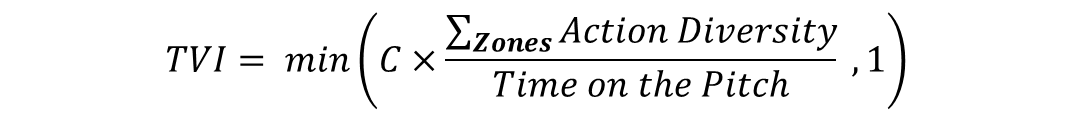

Where the action diversity is how many of the above mentioned actions the player did on that game. Only 1 action per type of action is considered.

C is the normalization constant, which in this case is 90/44 ~ 2.05, where 90 is the duration of a game, and 44 is the maximum number of possible distinct actions (pairs action, zone).

In [ ]:
# parameters
C = 90/44

In [ ]:
# pivot df on zone and event_type (this slightly complicates the index calculation but gives more explainability)
all_metric_events['event_zone'] = all_metric_events['event_name']+'_'+all_metric_events['zone'].astype('str')
tvi = all_metric_events.pivot_table(index=['game_id', 'team_id', 'player_id'],
                                      columns=['event_zone'],
                                      values='count').fillna(0).reset_index()\
                                      .reset_index(drop=True)

# Calculate action diversity by summing all columns (except indexes)
# each column can only contribute with maximum 1
event_zone_cols = [col for col in tvi.columns if col not in ['game_id', 'team_id', 'player_id']]
tvi['action_diversity'] = tvi[event_zone_cols].clip(upper=1).sum(axis=1)

# join time on pitch (time on pitch was already filtered for players that played > 30')
tvi = pd.merge(tvi, play_time, on=['game_id', 'team_id', 'player_id'], how='right')\
  .fillna(0)  # fill for players that didn't have any of the selected actions (we want their TVI to be 0)

# calculate TVI
tvi['TVI'] = C * tvi['action_diversity'] / tvi['play_time']
tvi['TVI'] = tvi['TVI'].clip(upper=1)
tvi.sort_values('TVI', ascending=False)

,game_id,team_id,player_id,Aerial_1,Aerial_2,Aerial_3,Aerial_4,Aerial_5,Aerial_6,Interception_1,Interception_2,Interception_3,Interception_4,Interception_5,Interception_6,Tackle_1,Tackle_2,Tackle_3,Tackle_4,Tackle_5,Tackle_6,Take On_1,Take On_2,Take On_3,Take On_4,Take On_5,Take On_6,deep_completition_1,deep_completition_2,deep_completition_3,deep_completition_4,deep_completition_5,deep_completition_6,key_pass_1,key_pass_2,key_pass_3,key_pass_4,key_pass_5,key_pass_6,progressive_pass_1,progressive_pass_2,progressive_pass_3,progressive_pass_4,progressive_pass_5,progressive_pass_6,shots_on_target_1,shots_on_target_2,shots_on_target_3,shots_on_target_4,shots_on_target_5,shots_on_target_6,action_diversity,play_time,TVI
6616,2133403,251,80590,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,30.0,0.613636
6680,2133472,255,453313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,32.0,0.575284
6760,2133423,251,244748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,32.0,0.575284
6804,2133350,1981,165803,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,33.0,0.557851
6574,2133248,740,178406,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,45.0,0.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6874,2133345,3536,167783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.000000
2527,2133294,196,245035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.000000
6587,2133280,6685,219095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.000000
4645,2133385,2847,222982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.000000


## group per player

In [ ]:
def weighted_avg(df, weight_column):
    """
    Computes the weighted average of all numeric columns in a DataFrame for a groupby operation.

    Parameters:
    df (pd.DataFrame): Grouped DataFrame subset.
    weight_column (str): Column name that contains the weights.

    Returns:
    pd.Series: Weighted average of each column in the group.
    """
    weights = df[weight_column]
    weighted_sum = df.drop(columns=[weight_column]).mul(weights, axis=0).sum()
    total_weight = weights.sum()

    return weighted_sum / total_weight if total_weight != 0 else None

In [ ]:
# add defensive/progressive/offensive actions per zone to reduce number of columns
tvi_final = tvi.copy()

columns_to_order = []
for zone in set(zone_map):
  tvi_final['defensive_zone_'+str(zone)] = tvi['Aerial_'+str(zone)] + \
    tvi['Interception_'+str(zone)] + tvi['Tackle_'+str(zone)]

  tvi_final['progressive_zone_'+str(zone)] = tvi['Take On_'+str(zone)] + \
    tvi['progressive_pass_'+str(zone)]

  tvi_final['offensive_zone_'+str(zone)] = tvi['deep_completition_'+str(zone)] + \
    tvi['key_pass_'+str(zone)] + tvi['shots_on_target_'+str(zone)]

  tvi_final.drop(columns=['Aerial_'+str(zone), 'Interception_'+str(zone), 'Tackle_'+str(zone),
                    'Take On_'+str(zone), 'progressive_pass_'+str(zone),
                    'deep_completition_'+str(zone), 'key_pass_'+str(zone),
                    'shots_on_target_'+str(zone)], inplace=True)

  columns_to_order.extend(['defensive_zone_'+str(zone), 'progressive_zone_'+str(zone), 'offensive_zone_'+str(zone)])



# group per player using weighted averages
tvi_final = tvi_final.drop(columns=['team_id','game_id'])\
  .groupby('player_id').apply(weighted_avg, weight_column='play_time').reset_index()

# add total play_time
total_play_time = tvi.groupby('player_id')['play_time'].sum().reset_index()
tvi_final = pd.merge(tvi_final, total_play_time, on='player_id', how='left')

# order columns
tvi_final = tvi_final[['player_id', 'action_diversity', 'play_time', 'TVI'] +
                      columns_to_order]

tvi_final.sort_values('TVI', ascending=False)

,player_id,action_diversity,play_time,TVI,defensive_zone_1,progressive_zone_1,offensive_zone_1,defensive_zone_2,progressive_zone_2,offensive_zone_2,defensive_zone_3,progressive_zone_3,offensive_zone_3,defensive_zone_4,progressive_zone_4,offensive_zone_4,defensive_zone_5,progressive_zone_5,offensive_zone_5,defensive_zone_6,progressive_zone_6,offensive_zone_6
223,220081,5.000000,31.0,0.329912,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
48,131416,10.560948,886.0,0.313975,0.314898,0.518059,0.0,0.510158,0.551919,0.0,0.835214,2.340858,0.310384,2.843115,3.668172,0.162528,0.296840,0.203160,0.609481,0.630926,1.293454,0.416479
414,493985,9.867749,431.0,0.308479,0.000000,0.169374,0.0,1.619490,0.000000,0.0,0.208817,1.046404,0.626450,1.338747,1.800464,0.939675,0.157773,0.464037,0.948956,0.301624,1.726218,2.510441
329,438098,9.022026,227.0,0.297357,0.000000,0.000000,0.0,0.607930,0.607930,0.0,0.559471,0.969163,0.303965,0.806167,1.854626,0.303965,0.000000,0.361233,0.303965,0.000000,4.039648,3.559471
362,453313,6.880734,109.0,0.281485,0.000000,0.000000,0.0,1.412844,0.000000,0.0,0.293578,0.000000,0.000000,0.706422,2.000000,0.000000,0.706422,0.000000,0.000000,0.293578,3.000000,3.706422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,114269,1.000000,90.0,0.022727,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
253,228531,1.000000,90.0,0.022727,0.000000,3.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
433,514151,1.000000,90.0,0.022727,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
230,222628,0.419355,155.0,0.013196,0.000000,0.838710,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Add player names

In [ ]:
# pandas read excel
player_name = pd.read_excel(player_name_path)
player_name.head()

,player_id,player_name,team_ids,team_name,position,birth_date,nationality,height,weight,join_date
0,200597,André Moreira,2030,Belenenses,Goalkeeper,1995-12-02,Portugal,195,90,2019-07-30
1,449983,João Monteiro,2030,Belenenses,Goalkeeper,2001-05-07,Portugal,186,80,2019-11-09
2,153378,Stanislav Kritsyuk,2030,Belenenses,Goalkeeper,1990-12-01,Russia,192,85,2020-09-29
3,209852,Guilherme Oliveira,2030,Belenenses,Goalkeeper,1995-04-12,Portugal,190,83,2018-07-03
4,475501,Diogo Calila,2030,Belenenses,Defender,1998-10-10,Portugal,180,73,2019-01-18


In [ ]:
tvi_final['player_id'] = tvi_final['player_id'].astype('int')
tvi_final_wNames = pd.merge(player_name, tvi_final, on='player_id', how='right')\
  .sort_values('TVI', ascending=False).reset_index(drop=True)

# exclude goalkeepers (the metric doesn't apply to gks)
tvi_final_wNames = tvi_final_wNames[tvi_final_wNames['position'] != 'Goalkeeper']

tvi_final_wNames.head(20)

,player_id,player_name,team_ids,team_name,position,birth_date,nationality,height,weight,join_date,action_diversity,play_time,TVI,defensive_zone_1,progressive_zone_1,offensive_zone_1,defensive_zone_2,progressive_zone_2,offensive_zone_2,defensive_zone_3,progressive_zone_3,offensive_zone_3,defensive_zone_4,progressive_zone_4,offensive_zone_4,defensive_zone_5,progressive_zone_5,offensive_zone_5,defensive_zone_6,progressive_zone_6,offensive_zone_6
0,220081,Fernando Medeiros,1980.0,Portimonense,Midfielder,1996-02-10,Brazil,181,79,2019-10-19,5.000000,31.0,0.329912,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
1,131416,Gabriel Pires,251.0,Benfica,Midfielder,1993-09-18,Brazil,187,82,2018-08-27,10.560948,886.0,0.313975,0.314898,0.518059,0.000000,0.510158,0.551919,0.0,0.835214,2.340858,0.310384,2.843115,3.668172,0.162528,0.296840,0.203160,0.609481,0.630926,1.293454,0.416479
2,493985,Jhonata Robert,6644.0,FC Famalicão,Forward,1999-10-26,Brazil,179,71,2020-08-12,9.867749,431.0,0.308479,0.000000,0.169374,0.000000,1.619490,0.000000,0.0,0.208817,1.046404,0.626450,1.338747,1.800464,0.939675,0.157773,0.464037,0.948956,0.301624,1.726218,2.510441
3,438098,Fábio Vieira,201.0,FC Porto,Midfielder,2000-05-30,Portugal,170,58,2020-06-02,9.022026,227.0,0.297357,0.000000,0.000000,0.000000,0.607930,0.607930,0.0,0.559471,0.969163,0.303965,0.806167,1.854626,0.303965,0.000000,0.361233,0.303965,0.000000,4.039648,3.559471
4,453313,Gonzalo Plata,255.0,Sporting CP,Midfielder,2000-11-01,Ecuador,178,65,2019-02-01,6.880734,109.0,0.281485,0.000000,0.000000,0.000000,1.412844,0.000000,0.0,0.293578,0.000000,0.000000,0.706422,2.000000,0.000000,0.706422,0.000000,0.000000,0.293578,3.000000,3.706422
5,244748,Chiquinho,251.0,Benfica,Midfielder,1995-07-19,Portugal,175,66,2018-07-01,6.200000,220.0,0.278926,0.204545,0.000000,0.000000,0.000000,0.000000,0.0,0.145455,0.904545,0.000000,1.645455,1.013636,0.000000,0.000000,0.509091,0.636364,0.000000,1.545455,1.704545
6,504826,Pedro Amador,3536.0,Moreirense,Defender,1998-12-18,Portugal,181,73,2020-08-15,10.592593,243.0,0.260943,0.370370,0.000000,0.000000,2.370370,1.481481,0.0,0.259259,0.740741,0.370370,2.259259,4.629630,0.000000,0.000000,0.000000,0.000000,0.740741,2.222222,3.111111
7,501223,Jafar Salmani,1980.0,Portimonense,Midfielder,1997-01-12,IR Iran,173,70,2021-01-01,7.103139,223.0,0.256828,0.000000,0.000000,0.000000,1.242152,0.000000,0.0,0.000000,0.201794,0.000000,0.542601,1.076233,0.304933,0.000000,0.354260,0.556054,0.910314,1.457399,2.255605
8,101537,Felipe Anderson,201.0,FC Porto,Midfielder,1993-04-15,Brazil,175,70,2020-10-06,5.636364,88.0,0.255682,0.000000,0.000000,0.000000,1.090909,0.000000,0.0,0.000000,0.636364,0.000000,1.636364,0.636364,0.000000,0.000000,0.636364,0.636364,0.000000,1.000000,0.363636
9,500499,Miguel Bandarra,3217.0,SC Farense,Defender,1996-01-17,Portugal,182,75,2019-07-01,5.111111,81.0,0.252525,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.333333,5.333333,1.666667,0.000000,0.000000,0.000000,0.000000,0.555556,0.555556


# Results deep dive

In [ ]:
# filter out players with small playing time
time_threshold = 450 # minutes -> 5 full matches
tvi_final_wNames_filtered = tvi_final_wNames[tvi_final_wNames['play_time'] > time_threshold]\
  .sort_values('TVI', ascending=False).reset_index(drop=True)
tvi_final_wNames_filtered.head(20)

,player_id,player_name,team_ids,team_name,position,birth_date,nationality,height,weight,join_date,action_diversity,play_time,TVI,defensive_zone_1,progressive_zone_1,offensive_zone_1,defensive_zone_2,progressive_zone_2,offensive_zone_2,defensive_zone_3,progressive_zone_3,offensive_zone_3,defensive_zone_4,progressive_zone_4,offensive_zone_4,defensive_zone_5,progressive_zone_5,offensive_zone_5,defensive_zone_6,progressive_zone_6,offensive_zone_6
0,131416,Gabriel Pires,251.0,Benfica,Midfielder,1993-09-18,Brazil,187,82,2018-08-27,10.560948,886.0,0.313975,0.314898,0.518059,0.000000,0.510158,0.551919,0.000000,0.835214,2.340858,0.310384,2.843115,3.668172,0.162528,0.296840,0.203160,0.609481,0.630926,1.293454,0.416479
1,39765,Adel Taarabt,251.0,Benfica,Midfielder,1989-05-24,Morocco,185,77,2015-07-01,8.956037,1524.0,0.241589,0.133858,0.192913,0.049213,0.645013,0.288058,0.000000,0.234908,2.596457,0.176509,0.783465,3.063648,0.186352,0.154199,0.596457,0.971129,0.260499,2.013780,1.414042
2,203323,Carlos Valenzuela,6644.0,FC Famalicão,Midfielder,1997-04-22,Argentina,167,69,2020-08-03,8.599436,709.0,0.239454,0.000000,0.279267,0.000000,1.160790,0.100141,0.000000,0.100141,0.645980,0.126939,0.939351,1.234133,0.369535,0.000000,0.480959,0.449929,0.462623,2.860367,1.622003
3,154306,Iuri Medeiros,372.0,Sporting Braga,Midfielder,1994-07-10,Portugal,175,66,2020-08-03,8.224176,910.0,0.236014,0.000000,0.098901,0.000000,0.548352,0.116484,0.000000,0.049451,0.762637,0.071429,0.979121,1.531868,0.068132,0.090110,0.431868,0.700000,0.278022,2.675824,3.510989
4,120188,Otávio,201.0,FC Porto,Midfielder,1995-02-09,Brazil,171,65,2014-09-01,9.579131,2003.0,0.232833,0.295057,0.174738,0.000000,0.419870,0.084373,0.000000,0.292561,1.393410,0.253620,0.840739,3.471293,0.256615,0.216176,0.686470,1.368447,0.711433,3.364953,3.076885
5,179531,Éverton,251.0,Benfica,Forward,1996-03-22,Brazil,174,72,2020-08-14,8.108388,1836.0,0.223930,0.049020,0.049020,0.000000,0.347495,0.045207,0.000000,0.185730,0.531590,0.049020,1.474946,2.467320,0.174837,0.160675,0.424837,0.942266,0.000000,2.994009,2.704793
6,56491,Nicolás Gaitán,372.0,Sporting Braga,Midfielder,1988-02-23,Argentina,173,66,2020-08-11,7.006397,469.0,0.222427,0.000000,0.000000,0.000000,0.000000,0.157783,0.000000,0.174840,1.072495,0.633262,0.624733,2.439232,0.206823,0.066098,0.680171,0.471215,0.786780,3.773987,5.036247
7,78638,Sérgio Oliveira,201.0,FC Porto,Midfielder,1992-06-02,Portugal,181,72,2015-07-01,8.997297,2220.0,0.220209,0.193694,0.157207,0.000000,0.198649,0.222072,0.000000,0.182883,1.368468,0.191892,1.101351,2.344144,0.503604,0.274775,0.200000,1.482432,0.300000,3.346396,3.563063
8,116631,Gilberto,251.0,Benfica,Defender,1993-03-07,Brazil,181,74,2020-08-08,8.542069,1450.0,0.220063,0.580000,0.057241,0.062069,1.683448,0.574483,0.000000,0.000000,0.208276,0.000000,1.759310,4.047586,0.098621,0.124138,0.062069,0.288966,0.475172,2.824828,2.379310
9,210237,Marko Grujic,201.0,FC Porto,Midfielder,1996-04-13,Serbia,191,86,2020-10-06,7.836391,654.0,0.215805,0.250765,0.000000,0.000000,0.631498,0.000000,0.000000,0.470948,1.836391,0.000000,3.295107,2.925076,0.126911,1.420489,0.163609,1.128440,0.623853,0.310398,0.402141


In [ ]:
tvi_final_wNames_filtered[['player_name', 'team_name', 'position', 'action_diversity', 'play_time', 'TVI']].head(20)

,player_name,team_name,position,action_diversity,play_time,TVI
0,Gabriel Pires,Benfica,Midfielder,10.560948,886.0,0.313975
1,Adel Taarabt,Benfica,Midfielder,8.956037,1524.0,0.241589
2,Carlos Valenzuela,FC Famalicão,Midfielder,8.599436,709.0,0.239454
3,Iuri Medeiros,Sporting Braga,Midfielder,8.224176,910.0,0.236014
4,Otávio,FC Porto,Midfielder,9.579131,2003.0,0.232833
5,Éverton,Benfica,Forward,8.108388,1836.0,0.223930
6,Nicolás Gaitán,Sporting Braga,Midfielder,7.006397,469.0,0.222427
7,Sérgio Oliveira,FC Porto,Midfielder,8.997297,2220.0,0.220209
8,Gilberto,Benfica,Defender,8.542069,1450.0,0.220063
9,Marko Grujic,FC Porto,Midfielder,7.836391,654.0,0.215805


In [ ]:
tvi_final_wNames_filtered[['player_name', 'team_name', 'position', 'action_diversity', 'play_time', 'TVI']].sort_values('action_diversity', ascending=False).head(20)

,player_name,team_name,position,action_diversity,play_time,TVI
0,Gabriel Pires,Benfica,Midfielder,10.560948,886.0,0.313975
4,Otávio,FC Porto,Midfielder,9.579131,2003.0,0.232833
12,Ryan Gauld,SC Farense,Midfielder,9.215508,2863.0,0.213619
7,Sérgio Oliveira,FC Porto,Midfielder,8.997297,2220.0,0.220209
1,Adel Taarabt,Benfica,Midfielder,8.956037,1524.0,0.241589
16,Jonatan Lucca,SC Farense,Midfielder,8.779510,1796.0,0.209557
10,Pedrinho,Gil Vicente,Midfielder,8.708840,1233.0,0.214001
29,Rúben Lima,Belenenses,Defender,8.639016,2845.0,0.198434
17,Willyan,Portimonense,Defender,8.634761,2382.0,0.209526
2,Carlos Valenzuela,FC Famalicão,Midfielder,8.599436,709.0,0.239454


# Views

In [ ]:
!pip install matplotsoccer
import matplotsoccer
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5966 sha256=67d365d1426dc15b493276edf19fca06a375b5534e72765b51c8d68071652e15
  Stored in directory: /root/.cache/pip/wheels/5f/96/51/a91e3de14cbbb035d664ca08bf412678bda3e5c7864f9ba66d
Successfully built matplotsoccer


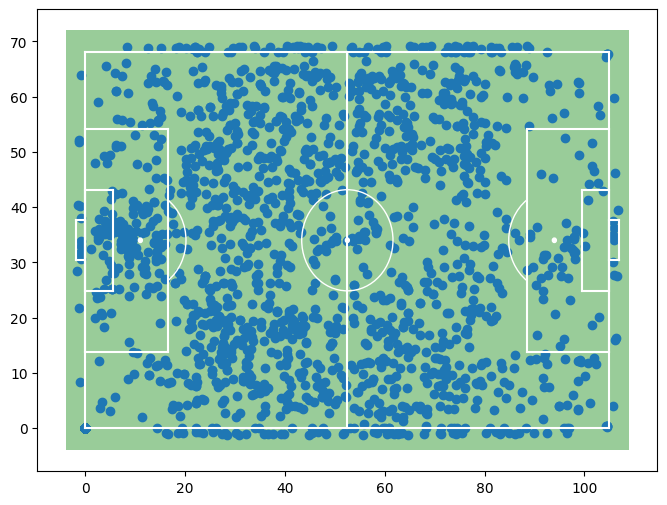

In [ ]:
matplotsoccer.field("green",figsize=8, show=False)
plt.scatter(match_events['x']*105/100,match_events['y']*68/100)
plt.axis("on")
plt.show()

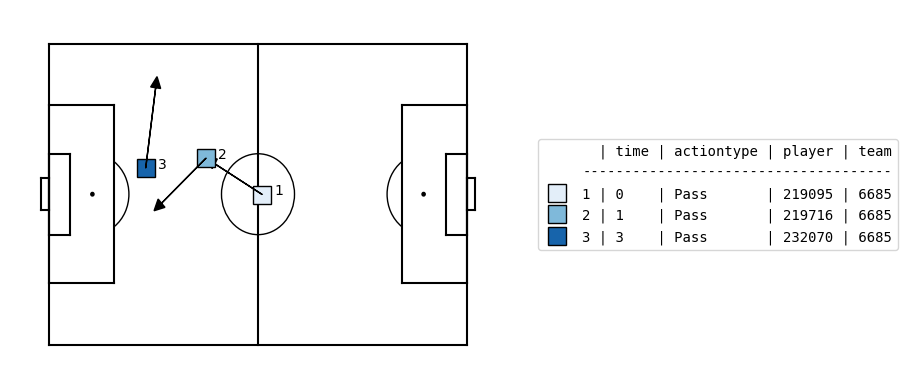

In [ ]:
passes = explode_event(match_events, 1, 0.15)
passes['end_x'] = passes["Pass End X"].astype('float')*105/100
passes['end_y'] = passes["Pass End Y"].astype('float')*68/100
passes['start_x'] = passes["x"].astype('float')*105/100
passes['start_y'] = passes["y"].astype('float')*68/100
actions_df = passes.head(3)
matplotsoccer.actions(
    location=actions_df[["start_x", "start_y", "end_x", "end_y"]],
    action_type=actions_df.event_name,
    team=actions_df.team_id,
    result= actions_df.outcome == '1',
    label=actions_df[["sec", "event_name", "player_id", "team_id"]],
    labeltitle=["time","actiontype","player","team"],
    zoom=False
)